In [1]:
import logging
from networkx import Graph
from numpy.random import randint

from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pandas import DataFrame

import matplotlib.pyplot as plt
from matplotlib import collections as mc
from pylab import rcParams, subplots

rcParams['figure.figsize'] = (25, 15)

from fastcluster import linkage
from scipy.cluster.hierarchy import cophenet, fcluster, dendrogram
from scipy.spatial.distance import pdist

from sklearn.cluster import KMeans

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO,
                    filename='../log/facebook.log')

In [2]:
SOURCE_PATH = '../datasets/facebook_combined.txt'

nodes = set([])
pairs = []

with open(SOURCE_PATH, 'r') as fin:
    for line in fin:
        xs = [x.strip() for x in line.split(' ')]
        nodes.update(xs)
        pairs += [xs]

# make graph, add nodes  
graph = Graph()
nodes = list(nodes)
graph.add_nodes_from(nodes)

# add edges (symmetrically)
graph.add_edges_from(pairs)
graph.add_edges_from([(y,x) for x,y in pairs])

In [3]:
def random_neighbor(x, graph=graph):
    ys = list(graph[x].keys())
    return ys[randint(low=0, high=len(ys))]


def random_chain(length, x0=None, graph=graph, nodes=nodes):
    if x0 is None:
        x0 = nodes[randint(low=0, high=len(nodes))]
    x = x0
    ys = [x0]
    for _ in range(length - 1):
        y = random_neighbor(x, graph)
        ys += [y]
        x = y
    return ys


class GraphRandomWalk(object):
    def __init__(self, n_chains, chain_len):
        self.n_chains = n_chains
        self.chain_len = chain_len
    def __iter__(self):
        for _ in range(self.n_chains - len(nodes)):
            # generate a chain
            chain = random_chain(self.chain_len)
            yield LabeledSentence(words=chain, tags=[chain[0]])
        for node in nodes:
            chain = random_chain(self.chain_len, node)
            yield LabeledSentence(words=chain, tags=[chain[0]])


def train_model(size, window):
    return Doc2Vec(GraphRandomWalk(80000, 25),
                   workers=5,
                   size=size, window=window, negative=20,
                   iter=10, alpha=0.1, min_count=1, sample=0)


# two models, different degrees of seperation
model_far = train_model(80, 6)
model_near = train_model(80, 2)

In [4]:
# PCA, t-SNE 

keys = list(model_far.wv.vocab.keys())
X = np.hstack([model_far.docvecs[keys],
               model_near.docvecs[keys],
               0.33 * model_near[keys]])

pca = PCA(50)
tsne = TSNE(2, metric='cosine', verbose=0)

Y = pca.fit_transform(X)
Z = tsne.fit_transform(Y)

print('sum(pca.explained_variance_ratio_) == ', np.sum(pca.explained_variance_ratio_))
print('tsne.kl_divergence_ == ', tsne.kl_divergence_)

sum(pca.explained_variance_ratio_) ==  0.458403868686
tsne.kl_divergence_ ==  1.7155903577804565


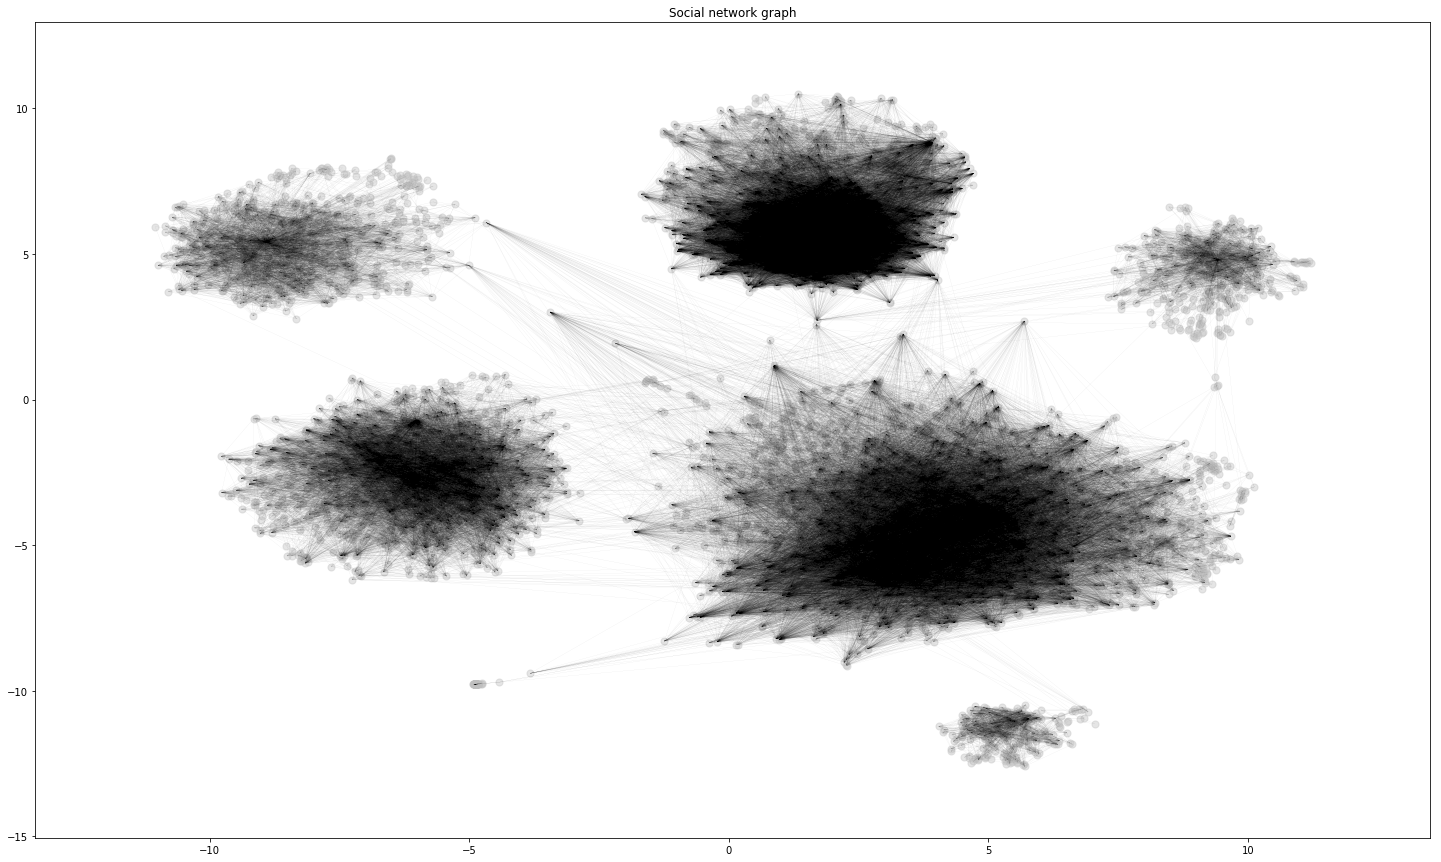

In [5]:
"""plot users and friendships in t-SNE space"""

# map from key to coordinate
df_key_x_y = (DataFrame({'key': keys,
                         'x': [Z[:, 0][keys.index(k)] for k in keys],
                         'y': [Z[:, 1][keys.index(k)] for k in keys]})
              .set_index('key'))


# pairs (edges/friendships) and their coordinates
df_pairs = (DataFrame({'key_1': [x for x,_ in pairs],
                       'key_2': [y for _,y in pairs]})
            .join(df_key_x_y, on='key_1')
            .join(df_key_x_y, on='key_2', rsuffix='2'))

def make_line(row):
    return [(row.x, row.y), (row.x2, row.y2)]

lines = list(df_pairs.apply(make_line, 1))

lc = mc.LineCollection(lines, linewidths=0.05, color = np.array([0, 0, 0, 0.4]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z[:, 0], Z[:, 1], s = 50, c = np.array([0.75, 0.75, 0.75, 0.4]))
plt.title('Social network graph')
plt.show()

0.626438043607


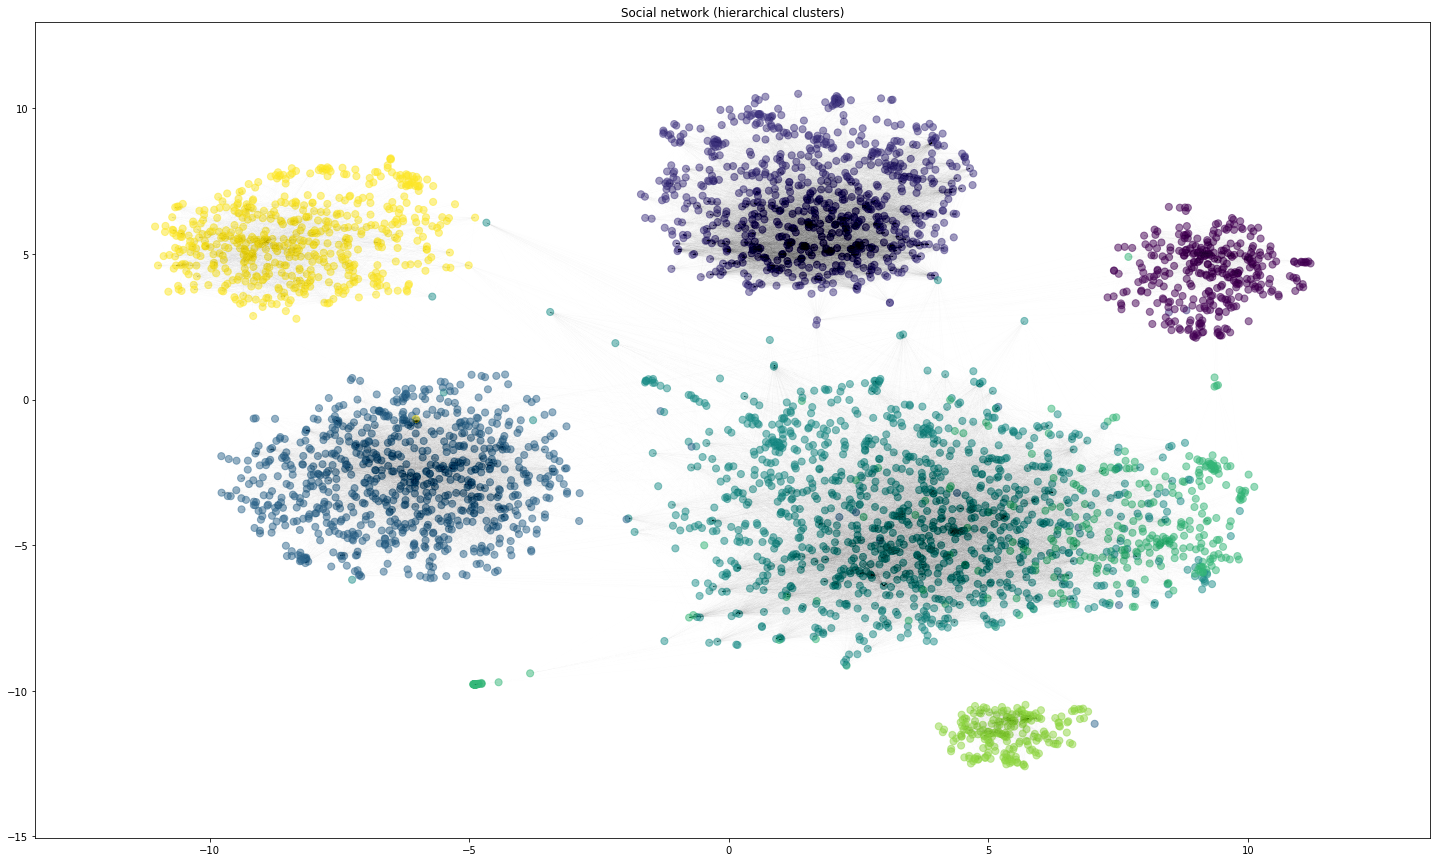

In [6]:
"""hierarchical clustering"""

W = linkage(X, method='ward', metric='cosine')
C_heirarchy = fcluster(W, 7, criterion='maxclust')

c, coph_dists = cophenet(W, pdist(Z))
print(c)

lc = mc.LineCollection(lines, linewidths=0.01, color = np.array([0, 0, 0, 0.2]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z[:, 0], Z[:, 1], s=50, c=C_heirarchy, alpha=0.5)
plt.title('Social network (hierarchical clusters)')
plt.show()

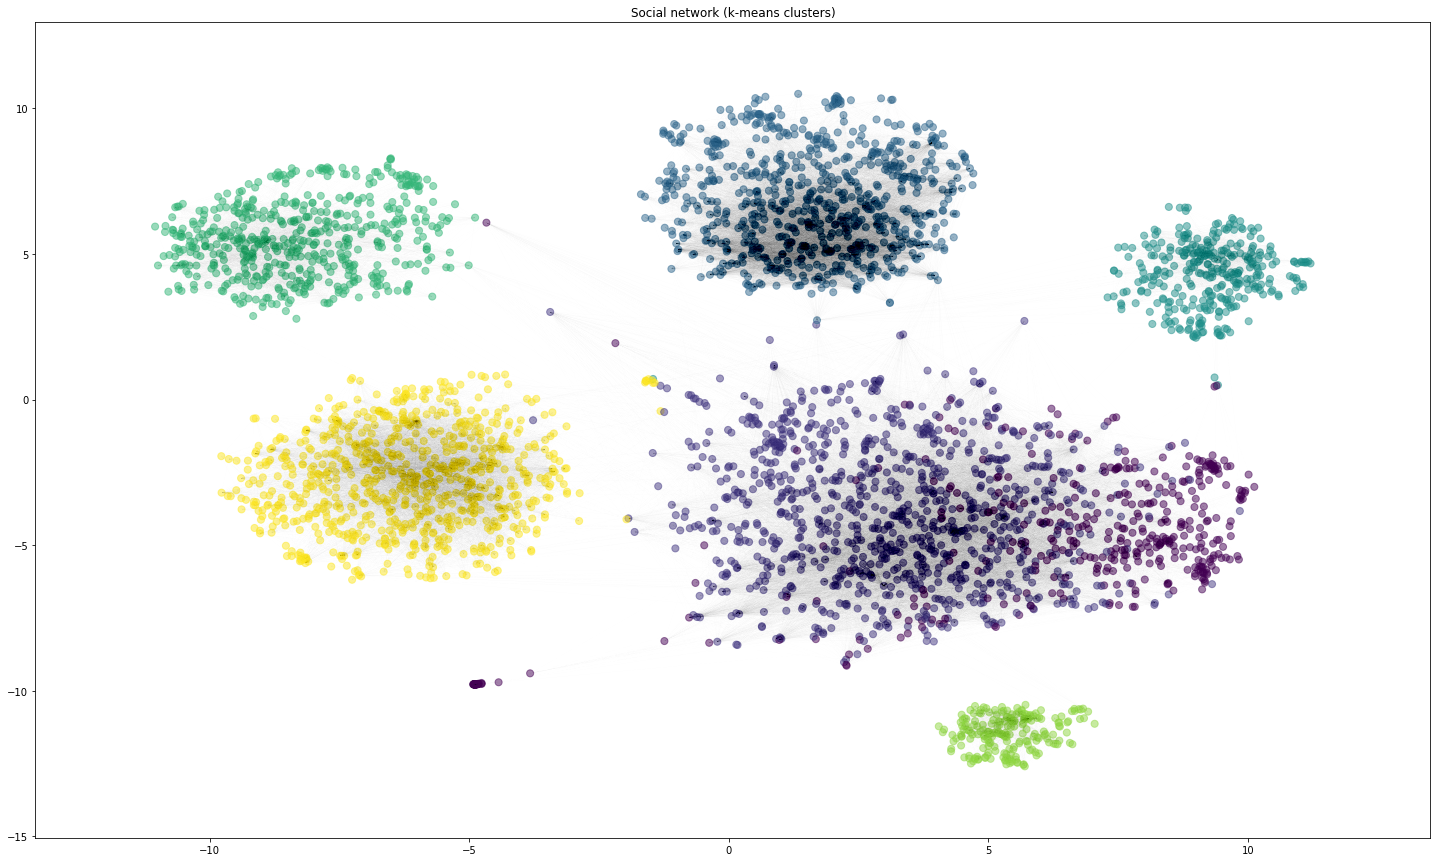

In [7]:
"""k-means clustering"""

C_kmeans = KMeans(7).fit_predict(X)

lc = mc.LineCollection(lines, linewidths=0.01, color = np.array([0, 0, 0, 0.2]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z[:, 0], Z[:, 1], s=50, c=C_kmeans, alpha=0.5)
plt.title('Social network (k-means clusters)')
plt.show()